### Graph Neural Network based Surrogate Models for Finite Element Methods for the Forging Process
- Shivaditya Meduri

Current simulation softwares use finite element method(FEM) to simulate metal forging processes. Finite Element methods consist of solving differential equations which can take a significant
amount of time for the simulation to complete. This is problematic when we try to use the simulation engine to find the best set of input parameters for the desired output as the parameter search
space exploration requires a lot of function calls and the time cost of a function call using the FEM
is very expensive. In this paper, we propose using Graph Neural Networks as a surrogate model
with cheap time cost as a proxy to the actual simulation engine for the task of parameter search
space exploration. We will discuss the forging process we are trying to simulate, how we modified
the mesh data into graphs, the graph pre-processing techniques, Graph Neural Network(GNN)
architectures tested, Training the GNNs, and finally evaluation of all the trained models.

In [2]:
import numpy
import torch
import pandas
import pyvista
import glob
import time
import sys
import dgl
import dgl.data
import os
import dgl.dataloading
import tqdm
import matplotlib.pyplot
import sklearn
import sklearn.model_selection
import sklearn.metrics
pyvista.set_jupyter_backend('pythreejs')

Using backend: pytorch


#### Converting Mesh data structure to Graph data structure
A graph needs nodes and edges to be defined. The nodes and edges may have features as well. We can extract node features from cells/points features of the mesh. We can extract the edge connectivity information using the mesh topological connectivity of the mesh. Below, you will find a function that takes a mesh, adds s1(Temperature) and s2(Friction Coefficient) features to every node and returns a node_features and an edgeList for a graph.

In [3]:
def mesh2graph(mesh, s1, s2):
    '''
    Takes a Pyvista Mesh and returns 
    node features as np array as well 
    as edge list of the graph
    '''
    pc = numpy.array(mesh.extract_surface().points)
    poly = mesh.extract_all_edges()
    edgeList = numpy.asarray(poly.lines).reshape((-1, 3))[:, 1:]
    #ns = mesh.extract_surface().cell_data_to_point_data()['NORMALSTRESS']
    ws = mesh.extract_surface().cell_data_to_point_data()['WEAR']
    #fs = mesh.extract_surface().cell_data_to_point_data()['FLOWSTRESS']
    #data = numpy.append(pc, ns.reshape(-1, 1), axis=1)
    #data = numpy.append(data, fs.reshape(-1, 1), axis=1)
    s1 = numpy.array(pc.shape[0]*[s1]) ### Temperature parameter
    s2 = numpy.array(pc.shape[0]*[s2]) ### Friction Coefficient parameter
    data = numpy.append(pc, s1.reshape(-1, 1), axis=1) 
    data = numpy.append(data, s2.reshape(-1, 1), axis=1)
    data = numpy.append(data, ws.reshape(-1, 1), axis=1)
    return data, edgeList #### Final Input Mesh with all features    

#### Extracting the metadata for each of the mesh simulations tested
We will be training our GNN model on transvalor's simulations of the forging process to create a Yoke. The technician can input the Temperature and the Friction Coefficient parameter to alter the final output. 

In [4]:
data_files = pandas.read_csv(r"D:\Books\M2 trimester 2\CRP\Transvalor\pe_summary.csv")
data_files.head()

Folder Computations  CostFunction  Minimizables_0  \
0  1_Blocker    Gen0_Ind0      0.999742         3881.43   
1  3_Blocker    Gen0_Ind1      0.999193         1238.68   
2  5_Blocker    Gen0_Ind2      0.999744         3898.98   
3  7_Blocker    Gen0_Ind3      0.999192         1235.89   
4  9_Blocker    Gen1_Ind0      0.999147         1171.00   

   Actions_0::Initial_Temperature  Actions_1::param0  
0                          900.07           0.499960  
1                         1249.37           0.100200  
2                          900.07           0.100600  
3                         1249.23           0.499440  
4                         1248.56           0.499963

#### Loading Mesh files for training and testing
We will be training the proposed GNN model on predicting the final increment for 2 objects, which is the Upper Deformable Die and the Lower Deformable Die

In [6]:
ldd_paths = glob.glob("VTKdataset/ldds/*.vtk")
udd_paths = glob.glob("VTKdataset/udds/*.vtk")
len(ldd_paths), len(udd_paths) #### Number of samples in the 2 datasets

(40, 40)

### Sample viewing of the mesh object

In [9]:
path = ldd_paths[15]
ldd_mesh = pyvista.read(path)
ldd_mesh.plot()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

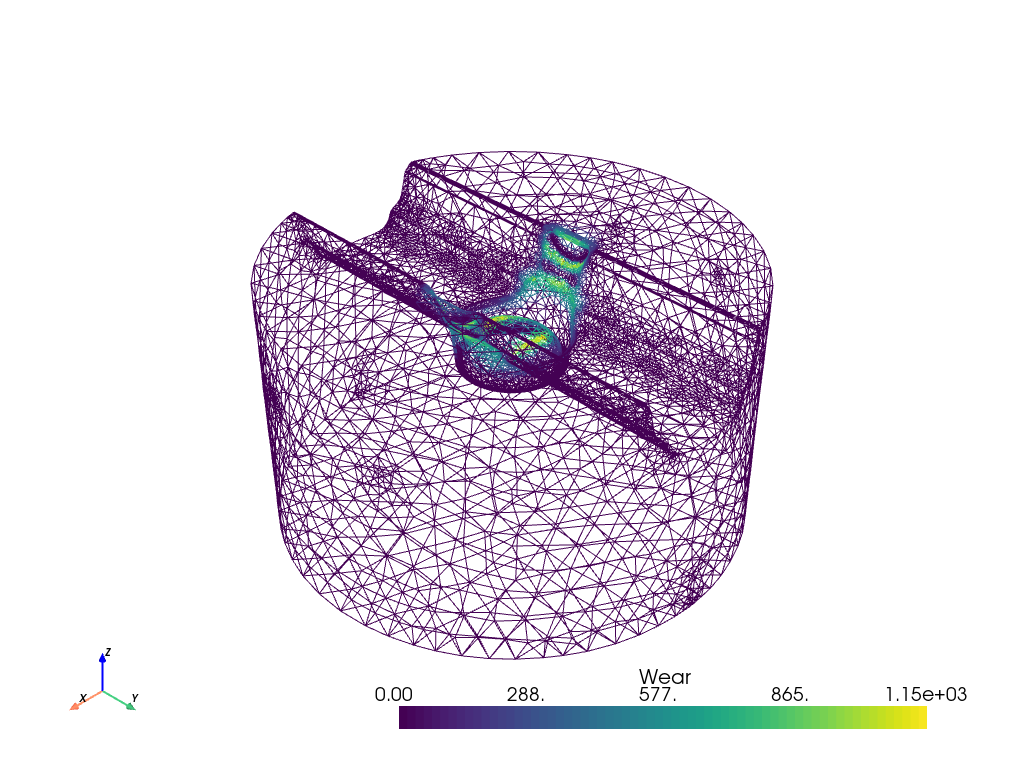

In [10]:
pyvista.global_theme.background = 'white'
pyvista.global_theme.font.color = 'black'  
mesh = ldd_mesh.extract_all_edges()
mesh.plot(scalars=mesh['WEAR'], scalar_bar_args={'title': "Wear"},jupyter_backend='static')

#### Loading all the LDD meshes and input parameters into an aggregated list
This will be used to create a DGL dataset for training the GNN model

In [16]:
#### Creating a LDD array from TSV paths
ns = 40
ldds, udds = [], []
print("Loading all the Lower Deformable Die meshes ..........")
for path in tqdm.tqdm(ldd_paths[:ns]):
    ldd_mesh = pyvista.read(path)
    obj = path.split("\\")[-1].split(".")[0] ## Extract the folder name of the object
     ## Extract the temperature value for that folder object
    s_1 = data_files[data_files['Folder'] == obj].values[0, 4]
     ## Extract the friction coefficient value for that folder object
    s_2 = data_files[data_files['Folder'] == obj].values[0, 5]
     ## Get the Max Wear of the output LDD from the dataframe
    max_wear = data_files[data_files['Folder'] == obj].values[0, 3]
    ldds.append((mesh2graph(ldd_mesh, s_1, s_2), max_wear))
    del ldd_mesh
    time.sleep(.5)
print("Completed loading the LDD meshes ..........")
print("Now, Loading all the Upper Deformable Die meshes ........")
for path in tqdm.tqdm(udd_paths[:ns]):
    udd_mesh = pyvista.read(path)
    obj = path.split("\\")[-1].split(".")[0] ## Extract the folder name of the object
     ## Extract the temperature value for that folder object
    s_1 = data_files[data_files['Folder'] == obj].values[0, 4]
     ## Extract the friction coefficient value for that folder object
    s_2 = data_files[data_files['Folder'] == obj].values[0, 5]
     ## Get the Max Wear of the output LDD from the dataframe
    max_wear = data_files[data_files['Folder'] == obj].values[0, 3]
    udds.append((mesh2graph(udd_mesh, s_1, s_2), max_wear))
    del udd_mesh
    time.sleep(.5)
print("Completed loading all the UDD meshes ........")

Loading all the Lower Deformable Die meshes ..........


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]


Completed loading the LDD meshes ..........
Now, Loading all the Upper Deformable Die meshes ........


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.71it/s]

Completed loading all the UDD meshes ........


### Creating a PyTorch dataset

In [17]:
print("Lower Deformable Die shape : ", ldds[0][0][0].shape) 
print("Upper Deformable Die shape : ", udds[0][0][0].shape) ### 9215 nodes and 5 node_features for each mesh

Lower Deformable Die shape :  (9215, 6)
Upper Deformable Die shape :  (6617, 6)


9215 nodes, 5 node_features and 1 target node feature for each lower deformable Die mesh.

6617 nodes, 5 node_features and 1 target node feature for each upper deformable Die mesh.


#### Creating a DGL dataset for training
__getitem__ will return output LDD/UDD mesh with features and targets

In [8]:
class TransvalorDatasetLDD(dgl.data.DGLDataset):
    #### Creating a DGL graph dataset
    #### This class object when called will return input mesh with features and target maxwear attribute
    def __init__(self):
        super().__init__(name='transvalor')
    
    def process(self):
        self.dataset = []
        for ((pc, edgeList), max_wear) in ldds:
            #### To create a graph datastructure, we need edgeList and NodeFeatures
            bdgl = dgl.graph((edgeList.T[0].tolist(), edgeList.T[1].tolist()),
                             num_nodes = pc.shape[0])
            bdgl.ndata['features'] = torch.Tensor(pc[:, :5])
            bdgl.ndata['label'] = torch.Tensor(pc[:, 5])
            bdgl = dgl.add_self_loop(bdgl)
            self.dataset.append(bdgl) 

    def __getitem__(self, i):
        return self.dataset[i]

    def __len__(self):
        return len(self.dataset)
    
class TransvalorDatasetUDD(dgl.data.DGLDataset):
    #### Creating a DGL graph dataset
    #### This class object when called will return input mesh with features and target maxwear attribute
    def __init__(self):
        super().__init__(name='transvalor')
    
    def process(self):
        self.dataset = []
        for ((pc, edgeList), max_wear) in udds:
            #### To create a graph datastructure, we need edgeList and NodeFeatures
            bdgl = dgl.graph((edgeList.T[0].tolist(), edgeList.T[1].tolist()),
                             num_nodes = pc.shape[0])
            bdgl.ndata['features'] = torch.Tensor(pc[:, :5])
            bdgl.ndata['label'] = torch.Tensor(pc[:, 5])
            bdgl = dgl.add_self_loop(bdgl)
            self.dataset.append(bdgl) 

    def __getitem__(self, i):
        return self.dataset[i]

    def __len__(self):
        return len(self.dataset)

ldd_dataset = TransvalorDatasetLDD()
udd_dataset = TransvalorDatasetUDD()

In [16]:
# Divide the dataset : 80% training and 20% testing
train_size = 30
test_size = 10
ldd_train_dataset, ldd_test_dataset = torch.utils.data.random_split(ldd_dataset, [train_size, test_size])
udd_train_dataset, udd_test_dataset = torch.utils.data.random_split(udd_dataset, [train_size, test_size])

### Defining a GNN model for the simulation's final increment prediction
We will be defining a graph neural network model, where the input is the Lower Deformable Die(LDD)/Upper Deformable Die(UDD) graph with spatial and input features; the output is the LDD graph/UDD graph with wear feature for each of the nodes.

In [17]:
##### This can also be done using native pytorch 
import dgl.nn
import torch.nn
import torch.nn.functional 

#### Creating a DGL GNN model
#### This model has 5 graph convolutional layers, followed by RELU activation
#### Regulariziation is achieved using dropouts

class dgl_GCN(torch.nn.Module):
    def __init__(self, in_feats, h_feats):
        super(dgl_GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, h_feats)
        self.conv2 = dgl.nn.GraphConv(h_feats, 2*h_feats)
        self.conv3 = dgl.nn.GraphConv(2*h_feats, 2*h_feats)
        self.conv4 = dgl.nn.GraphConv(2*h_feats, h_feats)
        self.conv5 = dgl.nn.GraphConv(h_feats, 1)
        self.dropout = torch.nn.Dropout(p=0.01)
        
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = torch.nn.functional.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)
        h = torch.nn.functional.relu(h)
        h = self.dropout(h)
        h = self.conv3(g, h)
        h = torch.nn.functional.relu(h)
        h = self.dropout(h)
        h = self.conv4(g, h)
        h = torch.nn.functional.relu(h)
        h = self.dropout(h)
        h = self.conv5(g, h)
        h = torch.nn.functional.relu(h)
        return h

#### Training the GNN model
We will train and test the model for the LDD and the UDD datasets. We will use Mean Squared Error, Coefficient of Determination(R2) and the Mean Percentage Error as ways to test the performance of the model.

In [18]:
##### Creating training and testing dataloaders for model training
ldd_train_dataloader = dgl.dataloading.GraphDataLoader(ldd_train_dataset, batch_size=1, drop_last=False)
ldd_test_dataloader = dgl.dataloading.GraphDataLoader(ldd_test_dataset, batch_size=1, drop_last=False)
udd_train_dataloader = dgl.dataloading.GraphDataLoader(udd_train_dataset, batch_size=1, drop_last=False)
udd_test_dataloader = dgl.dataloading.GraphDataLoader(udd_test_dataset, batch_size=1, drop_last=False)

#### Training and Testing the model's performance for the LDD object

Epoch :  0
Train Loss during epoch :  56789.50182291667
Test Loss during epoch :  82585.303515625
Epoch :  1
Train Loss during epoch :  55484.565104166664
Test Loss during epoch :  82172.7796875
Epoch :  2
Train Loss during epoch :  54988.181380208334
Test Loss during epoch :  81512.424609375
Epoch :  3
Train Loss during epoch :  54054.40442708333
Test Loss during epoch :  79644.440625
Epoch :  4
Train Loss during epoch :  52686.795703125
Test Loss during epoch :  77509.07265625
Epoch :  5
Train Loss during epoch :  50831.86484375
Test Loss during epoch :  75564.5931640625
Epoch :  6
Train Loss during epoch :  49218.65247395833
Test Loss during epoch :  73515.9234375
Epoch :  7
Train Loss during epoch :  47573.96829427083
Test Loss during epoch :  72675.1091796875
Epoch :  8
Train Loss during epoch :  46316.14049479167
Test Loss during epoch :  72566.578515625
Epoch :  9
Train Loss during epoch :  45006.871875
Test Loss during epoch :  72550.7736328125
Epoch :  10
Train Loss during epo

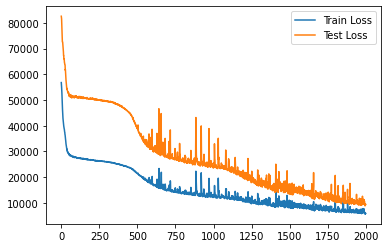

CPU times: total: 18h 45min 50s
Wall time: 1h 53min 39s


In [19]:
%%time
# Create the model with given dimensions
model = dgl_GCN(5, 50)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)#### optimizer to train the model
train_losses, test_losses = [], [] #### Record the training and the testing losses for plotting
for epoch in range(2000):
    print("Epoch : ", epoch)
    ###### Training the model ##########
    train_total_loss = 0
    model.train()
    for input_graph in ldd_train_dataloader:
        labels = input_graph.ndata['label']
        pred = model(input_graph, input_graph.ndata['features'])
        loss = torch.nn.functional.mse_loss(pred, labels.reshape(-1, 1)) ### MSE loss for model performance measurement
        optimizer.zero_grad() ##### resetting the gradients
        loss.backward() #### Updating the weights using torch autograd
        optimizer.step()
        train_total_loss += loss.detach().numpy() 
    print("Train Loss during epoch : ", train_total_loss/train_size)
    train_losses.append(train_total_loss/train_size)
    ########## Test dataset ##############
    model.eval()
    test_total_loss = 0
    for input_graph in ldd_test_dataloader:                       
        labels = input_graph.ndata['label']
        pred = model(input_graph, input_graph.ndata['features'])
        loss = torch.nn.functional.mse_loss(pred, labels.reshape(-1, 1)) ### MSE loss for model performance measurement
        test_total_loss += loss.detach().numpy()
    print("Test Loss during epoch : ", test_total_loss/test_size)
    test_losses.append(test_total_loss/test_size)
matplotlib.pyplot.plot(train_losses, label="Train Loss")
matplotlib.pyplot.plot(test_losses, label="Test Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [20]:
with open("LDDtrain_losses.txt", "w") as f:
    for loss in train_losses:
        f.write(str(loss) +"\n")
with open("LDDtest_losses.txt", "w") as f:
    for loss in test_losses:
        f.write(str(loss) +"\n")  
#### Read Files
# score = []
# with open("file.txt", "r") as f:
#     for line in f:
#     score.append(int(line.strip()))

In [21]:
#### Saving the model
torch.save(model, "LDDmodel.pt")
#### Loading the model
# model = torch.load("LDDmodel.pt")

In [22]:
test_total_loss = 0
for input_graph in ldd_test_dataloader:                       
    labels = input_graph.ndata['label']
    pred = model(input_graph, input_graph.ndata['features'])
    loss = torch.nn.functional.mse_loss(pred, labels.reshape(-1, 1)) ### MSE loss for model performance measurement
    test_total_loss += loss.detach().numpy()
test_avg_loss = test_total_loss/len(ldd_test_dataloader)
print("Root Mean Squared Error on the test set on average per node is : ", numpy.sqrt(test_avg_loss))
test_r2s = []
itera = iter(ldd_test_dataloader)
for i in range(10):
    test_graph = next(itera)
    actual_wear = test_graph.ndata['label']
    predicted_wear = model(test_graph, test_graph.ndata['features']).detach().numpy()
    test_r2s.append(sklearn.metrics.r2_score(predicted_wear[:, 0], actual_wear))
print("Average R2 on the test data is : ", numpy.array(test_r2s).mean())

Root Mean Squared Error on the test set on average per node is :  96.84810677619265
Average R2 on the test data is :  0.8939413955089479


In [77]:
path = ldd_paths[2]
output_LDD = tsvpylab.meshmanager.TSVMesh(path)
ldd_mesh = output_LDD.to_pyvista()
itera = iter(ldd_test_dataloader)

In [79]:
mesh = ldd_mesh['Surface'].extract_all_edges()
test_graph = next(itera)
actual_wear = test_graph.ndata['label']
predicted_wear = model(test_graph, test_graph.ndata['features']).detach().numpy()

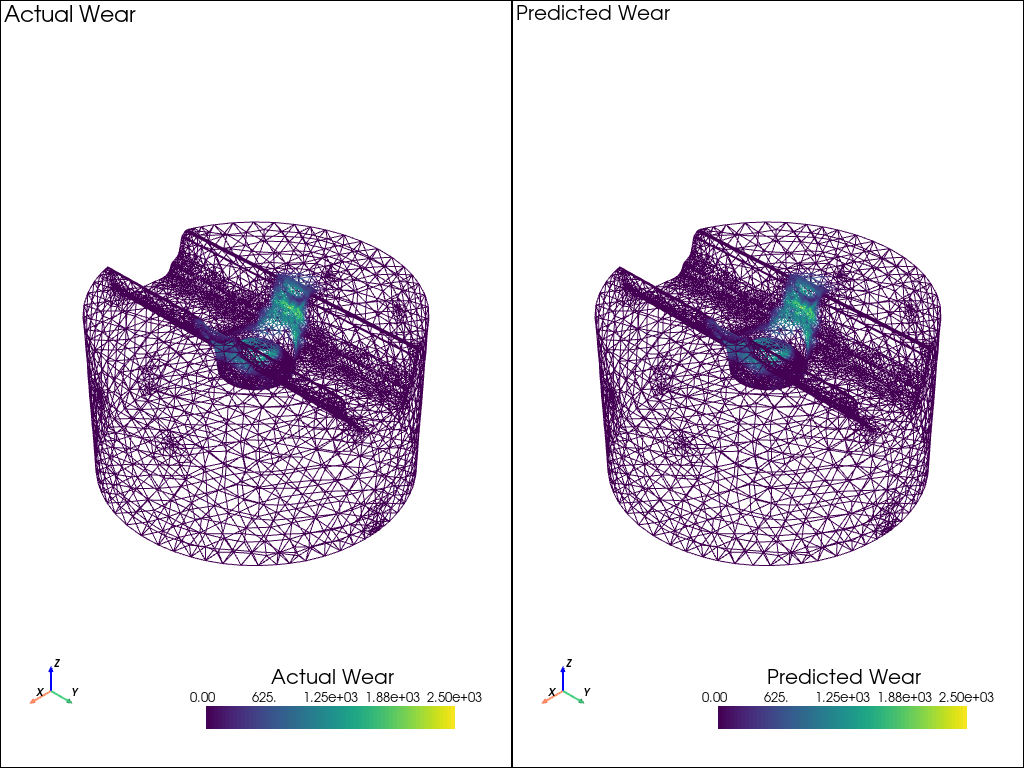

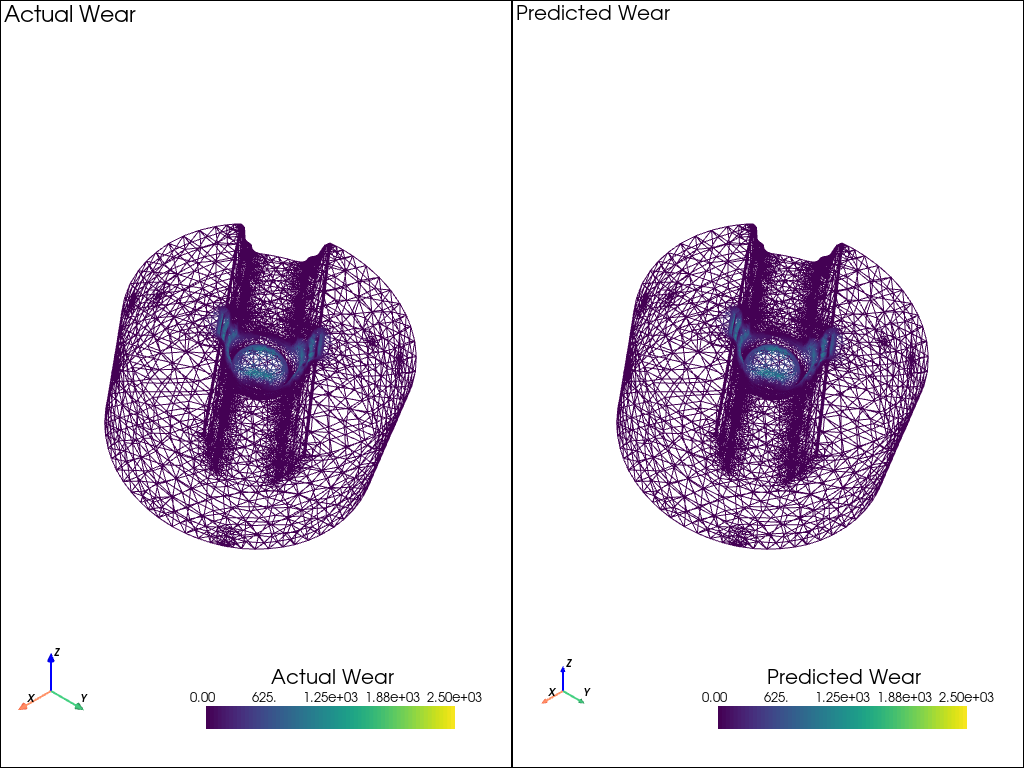

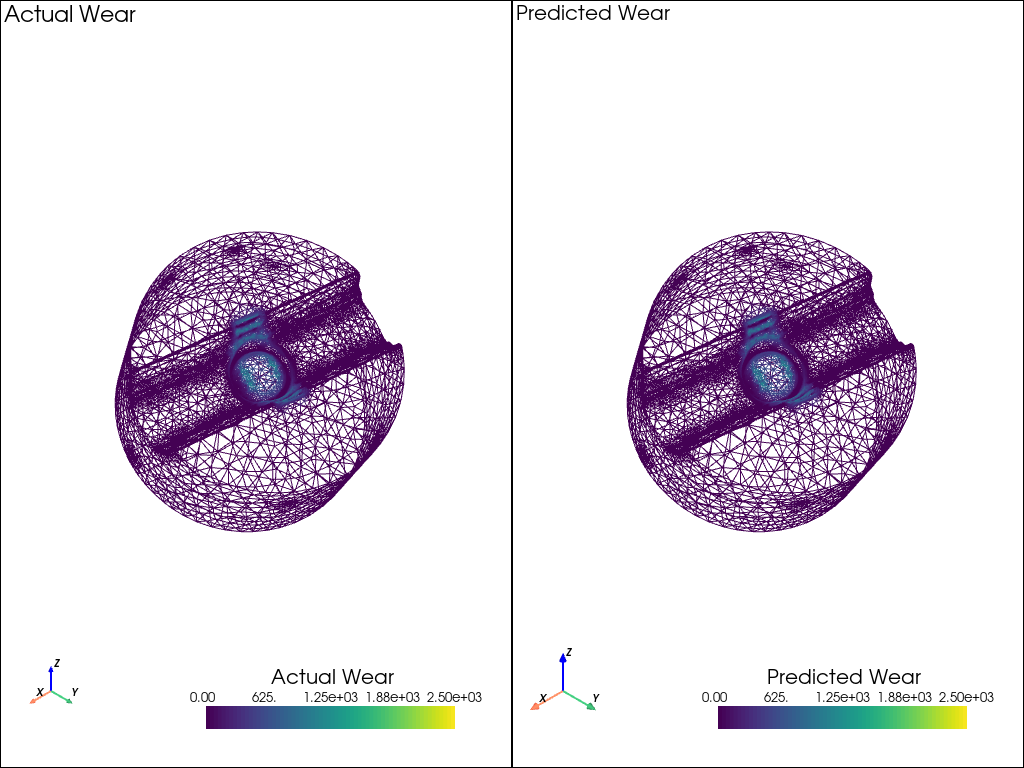

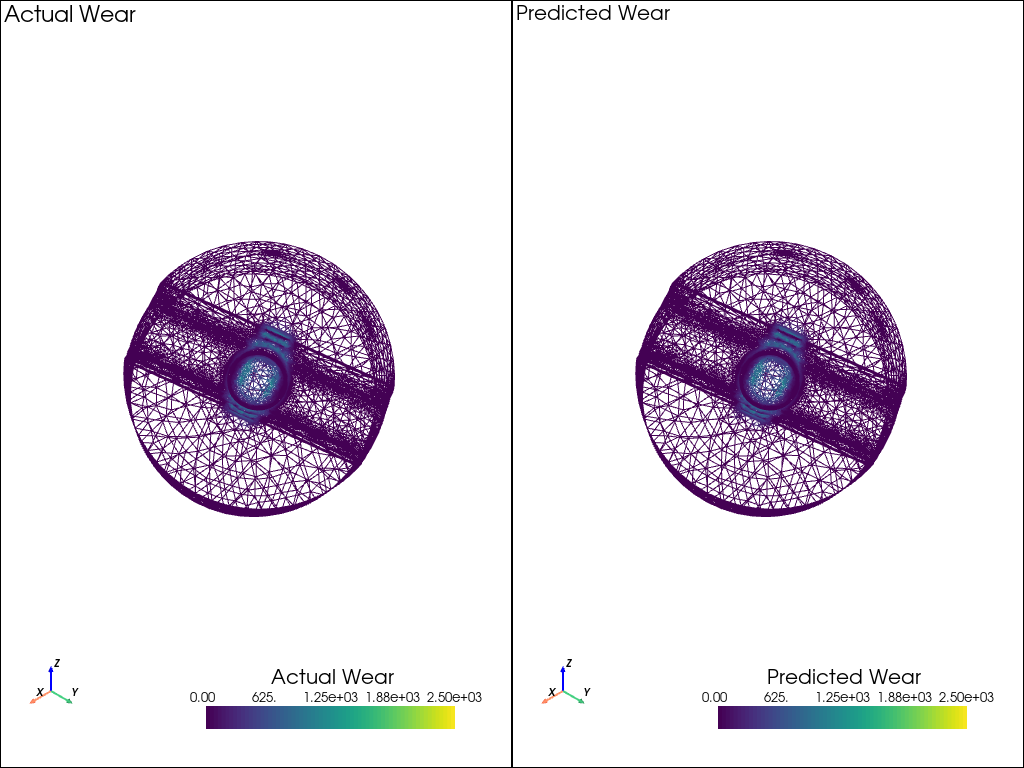

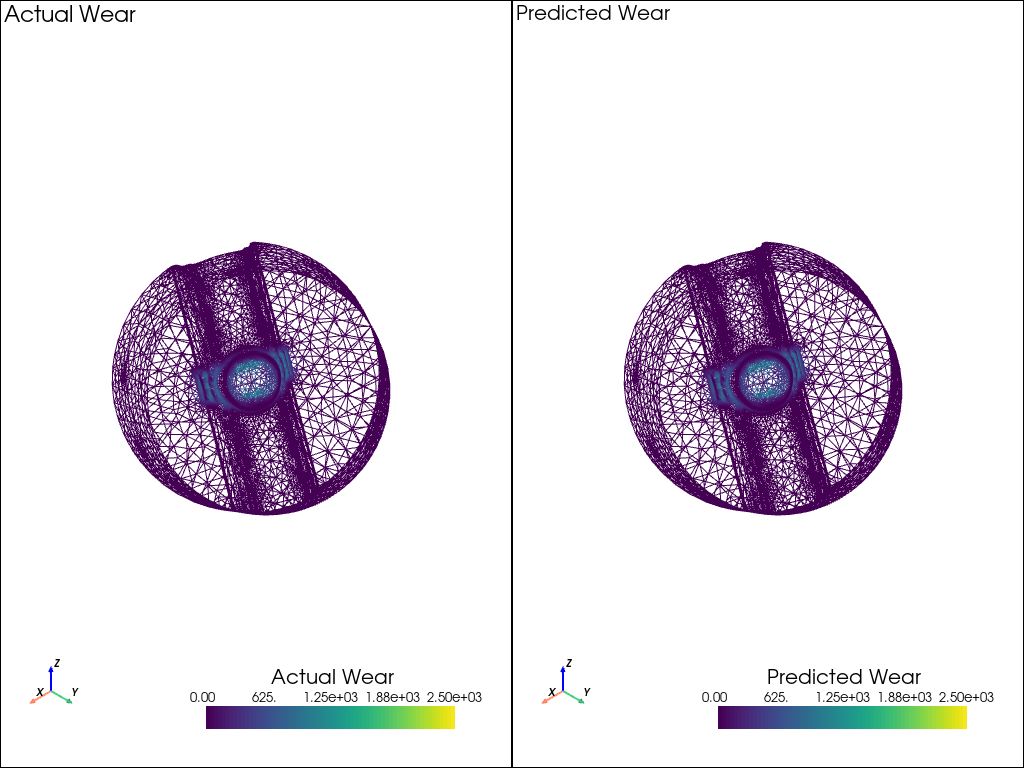

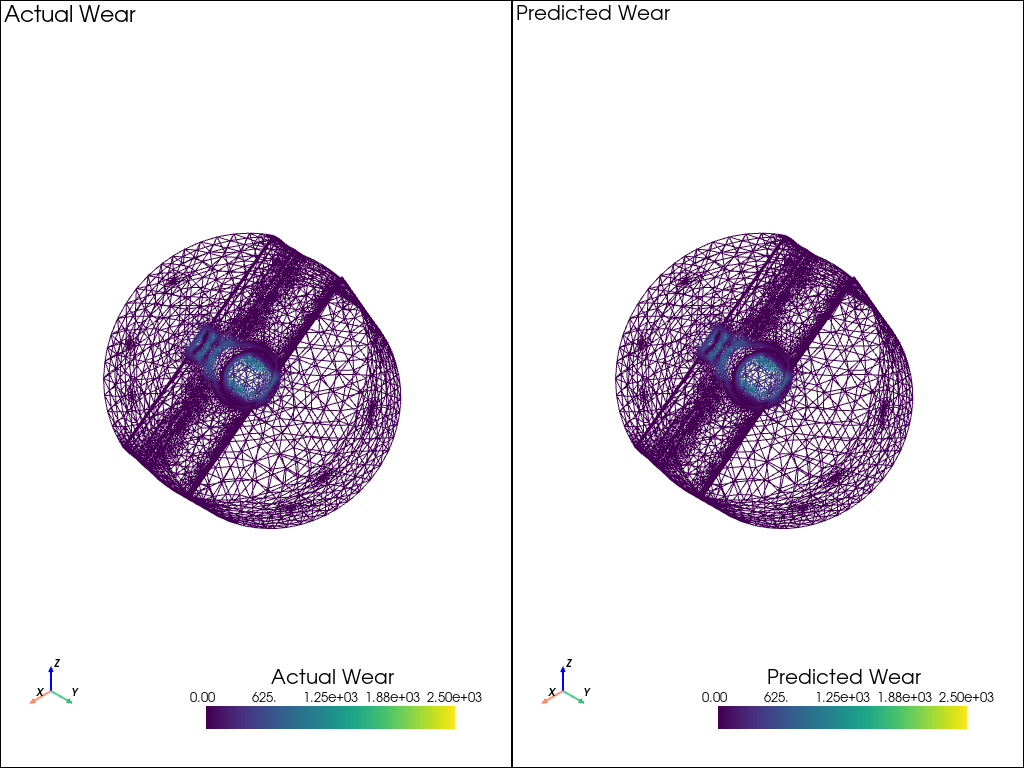

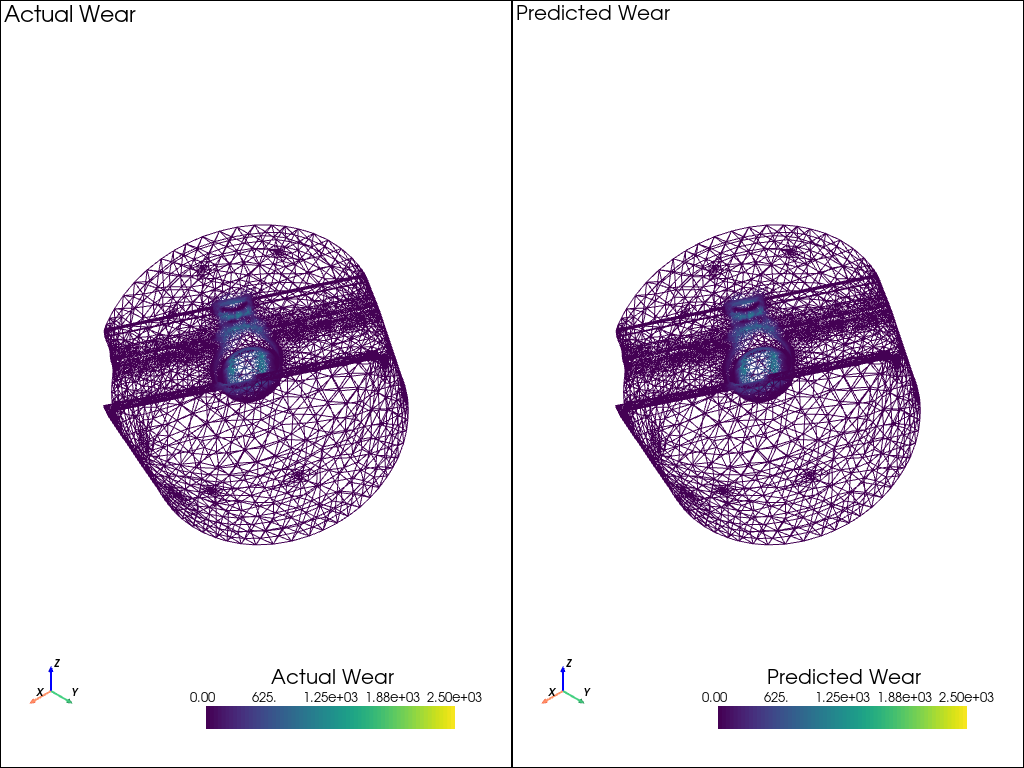

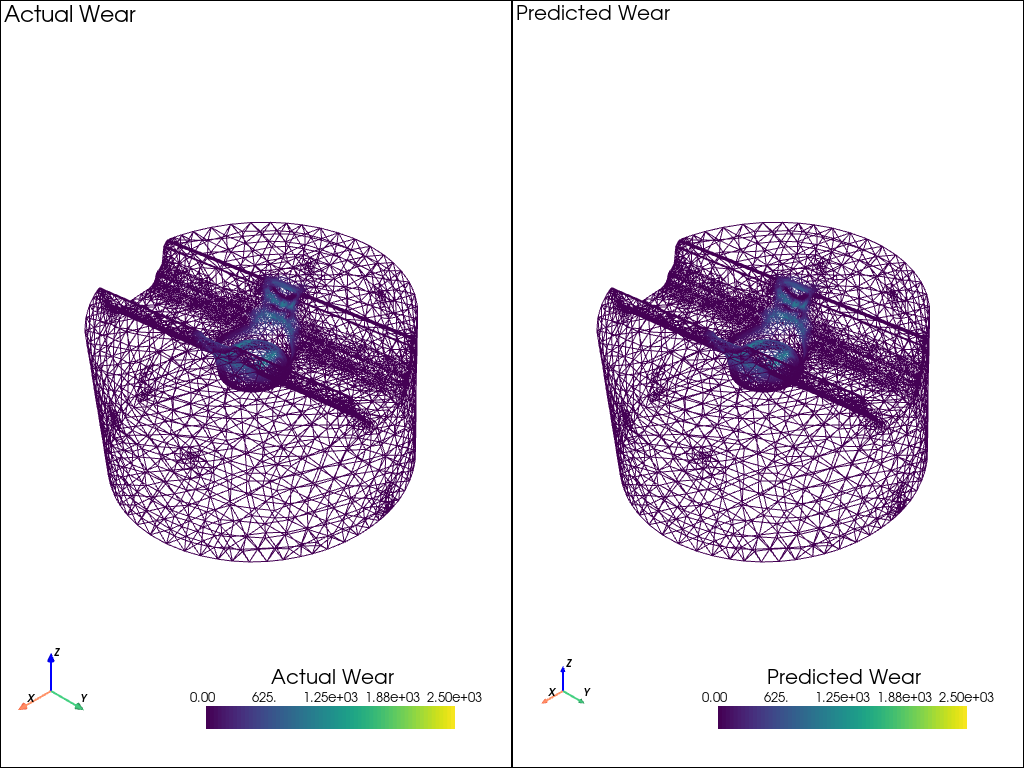

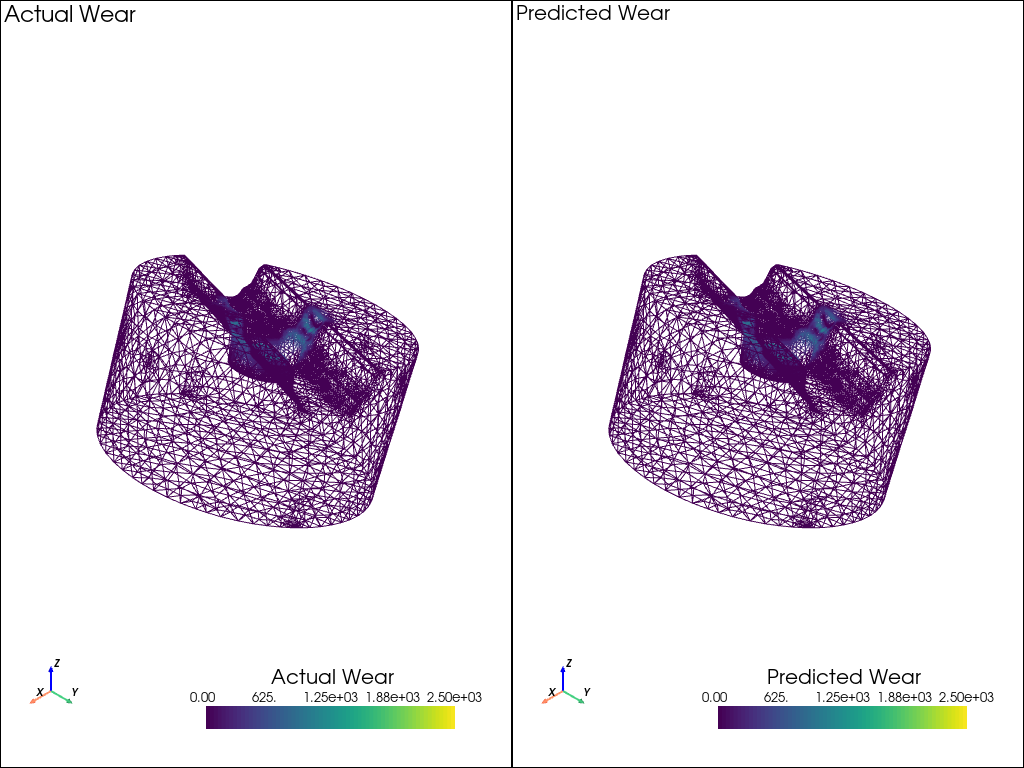

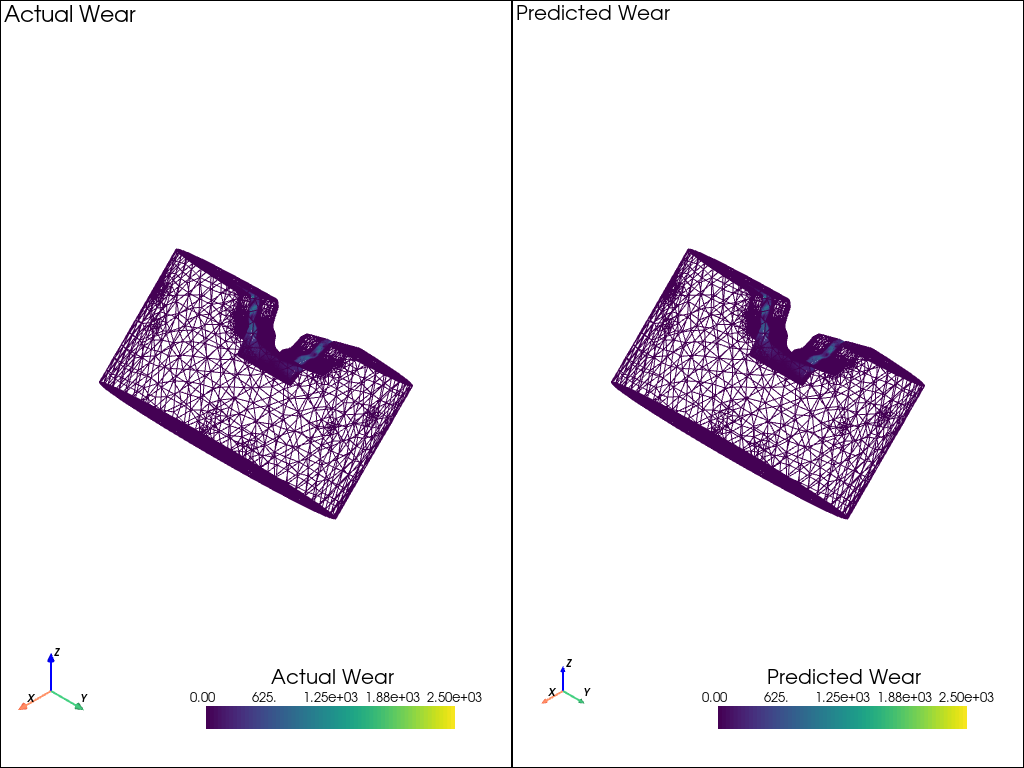

In [98]:
itera = iter(ldd_test_dataloader)
for i in range(10):
    test_graph = next(itera)
    actual_wear = test_graph.ndata['label']
    predicted_wear = model(test_graph, test_graph.ndata['features']).detach().numpy()
    mesh = ldd_mesh['Surface'].extract_all_edges()
    pyvista.global_theme.background = 'white'
    pyvista.global_theme.font.color = 'black'  

    plotter = pyvista.Plotter(shape=(1, 2))

    plotter.subplot(0, 0)
    plotter.add_text("Actual Wear", font_size=10, color="black")
    plotter.add_mesh(mesh.rotate_z(-25*i).rotate_x(-10*i), scalars=actual_wear, scalar_bar_args={'title': "Actual Wear"}, clim=[0, 2500])
    plotter.add_axes(interactive=True)

    plotter.subplot(0, 1)
    plotter.add_text("Predicted Wear", font_size=10, color="black")
    plotter.add_mesh(mesh.rotate_z(-25*i).rotate_x(-10*i), scalars=predicted_wear, scalar_bar_args={'title': "Predicted Wear"}, clim=[0, 2500])
    plotter.add_axes(interactive=True)

    plotter.show(jupyter_backend='static')
    plotter.screenshot(f'resimgs3dLDD/results_{i}.png')

<Figure size 800x800 with 0 Axes>

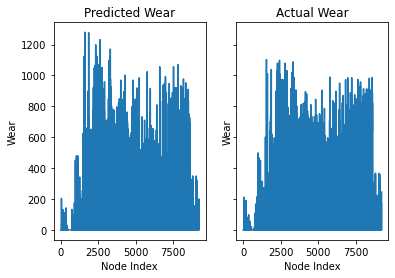

In [25]:
itera = iter(ldd_test_dataloader)
test_graph = next(itera)
actual_wear = test_graph.ndata['label']
predicted_wear = model(test_graph, test_graph.ndata['features']).detach().numpy()

matplotlib.pyplot.figure(figsize=(10, 10), dpi=80)

fig, axs = matplotlib.pyplot.subplots(1, 2, sharey=True)
axs[0].plot(predicted_wear)
axs[0].set_title("Predicted Wear")
axs[0].set_xlabel("Node Index")
axs[0].set_ylabel("Wear")
axs[1].plot(actual_wear)
axs[1].set_xlabel("Node Index")
axs[1].set_ylabel("Wear")
axs[1].set_title("Actual Wear")
matplotlib.pyplot.show()

In [31]:
numpy.save("lddactwe.npy", actual_wear.numpy())
numpy.save("lddprewe.npy", predicted_wear)
#actwe = np.load('lddactwe.npy') # load

In [ ]:
path = ldd_paths[0]
output_LDD = tsvpylab.meshmanager.TSVMesh(path)
ldd_mesh = output_LDD.to_pyvista()
mesh = ldd_mesh['Surface'].extract_all_edges()
mesh.plot(scalars=predicted_wear, scalar_bar_args={'title': "Wear"},)

In [ ]:
fig = matplotlib.pyplot.figure(figsize = (10, 7))
ax = matplotlib.pyplot.axes(projection ="3d")

# Creating plot
ax.scatter3D(-1*pc[:, 0],  -1*pc[:, 2], -1*pc[:, 1], c=predicted_wear)
matplotlib.pyplot.title("Predicted Wear")

# show plot
matplotlib.pyplot.show()

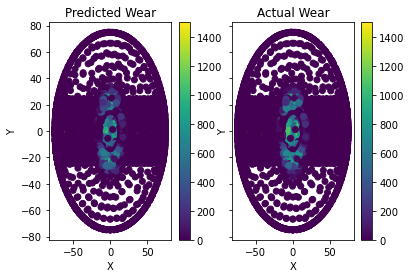

In [91]:
test_graph = next(itera)
actual_wear = test_graph.ndata['label']
predicted_wear = model(test_graph, test_graph.ndata['features']).detach().numpy()
fig, axs = matplotlib.pyplot.subplots(1, 2, sharey=True)
pc = test_graph.ndata['features'][:, :3]
im1 = axs[0].scatter(pc[:, 1], pc[:, 0], c=predicted_wear)
axs[0].set_title("Predicted Wear")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
im2 = axs[1].scatter(pc[:, 1], pc[:, 0], c=actual_wear)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Actual Wear")
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
im1.set_clim(0, 1500)
im2.set_clim(0, 1500)
matplotlib.pyplot.show()

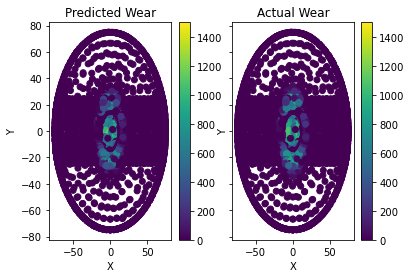

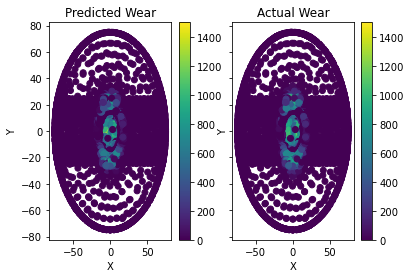

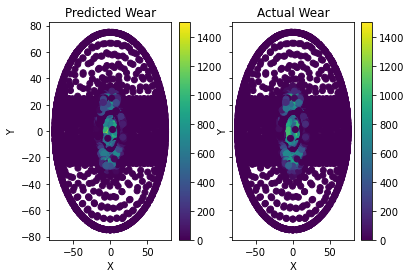

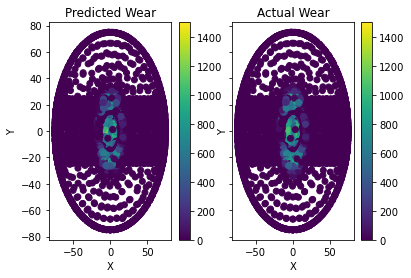

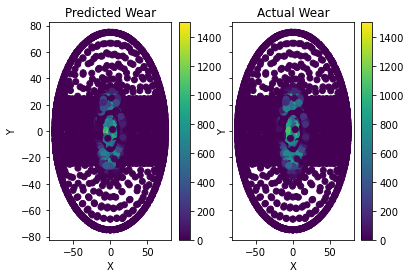

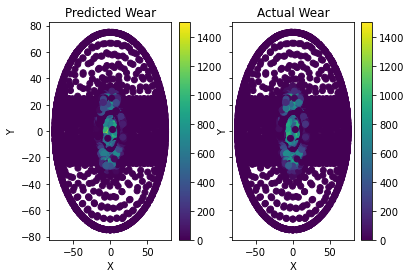

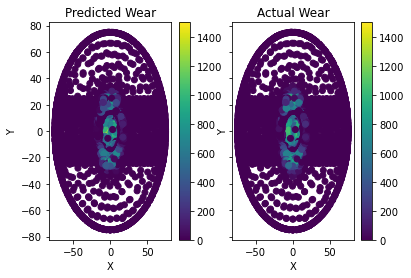

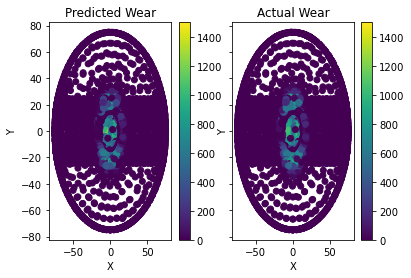

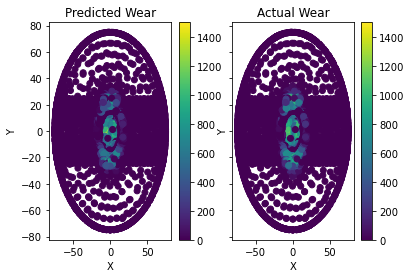

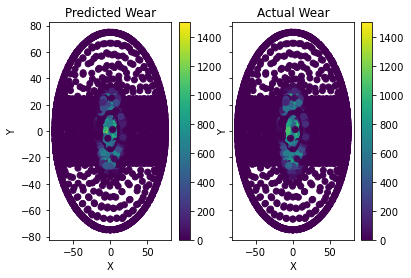

In [21]:
itera = iter(ldd_test_dataloader)
for i in range(10):
    test_graph = next(itera)
    actual_wear = test_graph.ndata['label']
    predicted_wear = model(test_graph, test_graph.ndata['features']).detach().numpy()
    fig, axs = matplotlib.pyplot.subplots(1, 2, sharey=True)
    pc = test_graph.ndata['features'][:, :3]
    im1 = axs[0].scatter(pc[:, 1], pc[:, 0], c=predicted_wear)
    axs[0].set_title("Predicted Wear")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    im2 = axs[1].scatter(pc[:, 1], pc[:, 0], c=actual_wear)
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Y")
    axs[1].set_title("Actual Wear")
    fig.colorbar(im1, ax=axs[0])
    fig.colorbar(im2, ax=axs[1])
    im1.set_clim(0, 1500)
    im2.set_clim(0, 1500)
    matplotlib.pyplot.savefig(f"resimgs2dLDD/res2D_{i}.png")
    matplotlib.pyplot.show()

#### Training and Testing the model's performance for the UDD object

Epoch :  0


C:\Users\shiva\anaconda3\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train Loss during epoch :  16224.16689453125
Test Loss during epoch :  12011.29384765625
Epoch :  1
Train Loss during epoch :  16013.57626953125
Test Loss during epoch :  11832.62529296875
Epoch :  2
Train Loss during epoch :  15841.46015625
Test Loss during epoch :  11664.04296875
Epoch :  3
Train Loss during epoch :  15619.609537760416
Test Loss during epoch :  11571.64296875
Epoch :  4
Train Loss during epoch :  15544.589453125
Test Loss during epoch :  11544.83212890625
Epoch :  5
Train Loss during epoch :  15273.808561197917
Test Loss during epoch :  11343.42939453125
Epoch :  6
Train Loss during epoch :  14984.501822916667
Test Loss during epoch :  10860.92861328125
Epoch :  7
Train Loss during epoch :  14658.64267578125
Test Loss during epoch :  10612.18701171875
Epoch :  8
Train Loss during epoch :  14389.093115234375
Test Loss during epoch :  10121.345166015624
Epoch :  9
Train Loss during epoch :  14088.496321614582
Test Loss during epoch :  9950.513720703126
Epoch :  10
Trai

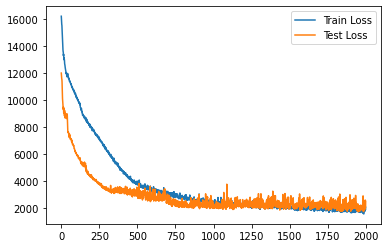

CPU times: total: 14h 37min 56s
Wall time: 1h 27min 14s


In [23]:
%%time
# Create the model with given dimensions
model_UDD = dgl_GCN(5, 50)
optimizer = torch.optim.Adam(model_UDD.parameters(), lr=8e-4)#### optimizer to train the model
train_losses, test_losses = [], [] #### Record the training and the testing losses for plotting
for epoch in range(2000):
    print("Epoch : ", epoch)
    ###### Training the model ##########
    train_total_loss = 0
    model_UDD.train()
    for input_graph in udd_train_dataloader:
        labels = input_graph.ndata['label']
        pred = model_UDD(input_graph, input_graph.ndata['features'])
        loss = torch.nn.functional.mse_loss(pred, labels.reshape(-1, 1)) ### MSE loss for model performance measurement
        optimizer.zero_grad() ##### resetting the gradients
        loss.backward() #### Updating the weights using torch autograd
        optimizer.step()
        train_total_loss += loss.detach().numpy() 
    print("Train Loss during epoch : ", train_total_loss/train_size)
    train_losses.append(train_total_loss/train_size)
    ########## Test dataset ##############
    model_UDD.eval()
    test_total_loss = 0
    for input_graph in udd_test_dataloader:                       
        labels = input_graph.ndata['label']
        pred = model_UDD(input_graph, input_graph.ndata['features'])
        loss = torch.nn.functional.mse_loss(pred, labels.reshape(-1, 1)) ### MSE loss for model performance measurement
        test_total_loss += loss.detach().numpy()
    print("Test Loss during epoch : ", test_total_loss/test_size)
    test_losses.append(test_total_loss/test_size)
matplotlib.pyplot.plot(train_losses, label="Train Loss")
matplotlib.pyplot.plot(test_losses, label="Test Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [24]:
with open("UDDtrain_losses.txt", "w") as f:
    for loss in train_losses:
        f.write(str(loss) +"\n")
with open("UDDtest_losses.txt", "w") as f:
    for loss in test_losses:
        f.write(str(loss) +"\n")  
#### Read Files
# score = []
# with open("file.txt", "r") as f:
#     for line in f:
#     score.append(int(line.strip()))

In [23]:
#### Saving the model
torch.save(model_UDD, "UDDmodel.pt")
#### Loading the model
# model_UDD = torch.load("UDDmodel.pt")

In [24]:
path = udd_paths[0]
output_UDD = tsvpylab.meshmanager.TSVMesh(path)
udd_mesh = output_UDD.to_pyvista()
mesh = udd_mesh['Surface'].extract_all_edges()

C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\pyvista\core\pointset.py:328: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)
C:\Users\shiva\AppData\Roaming\Python\Python39\site-packages\pyvista\core\pointset.py:310: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


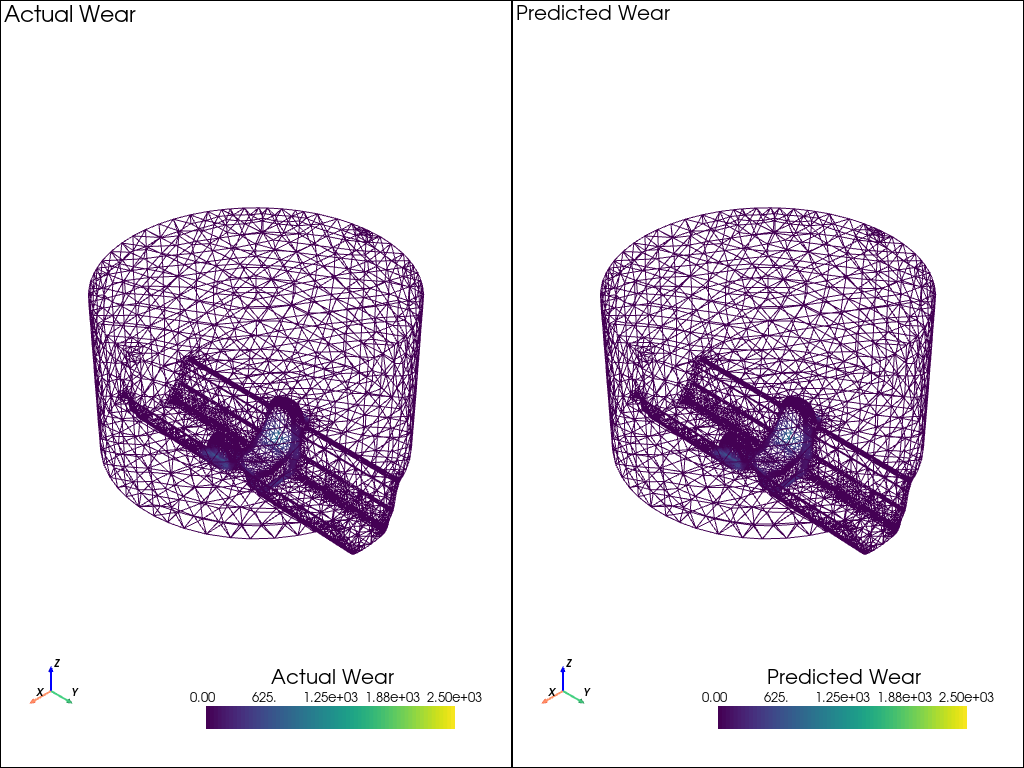

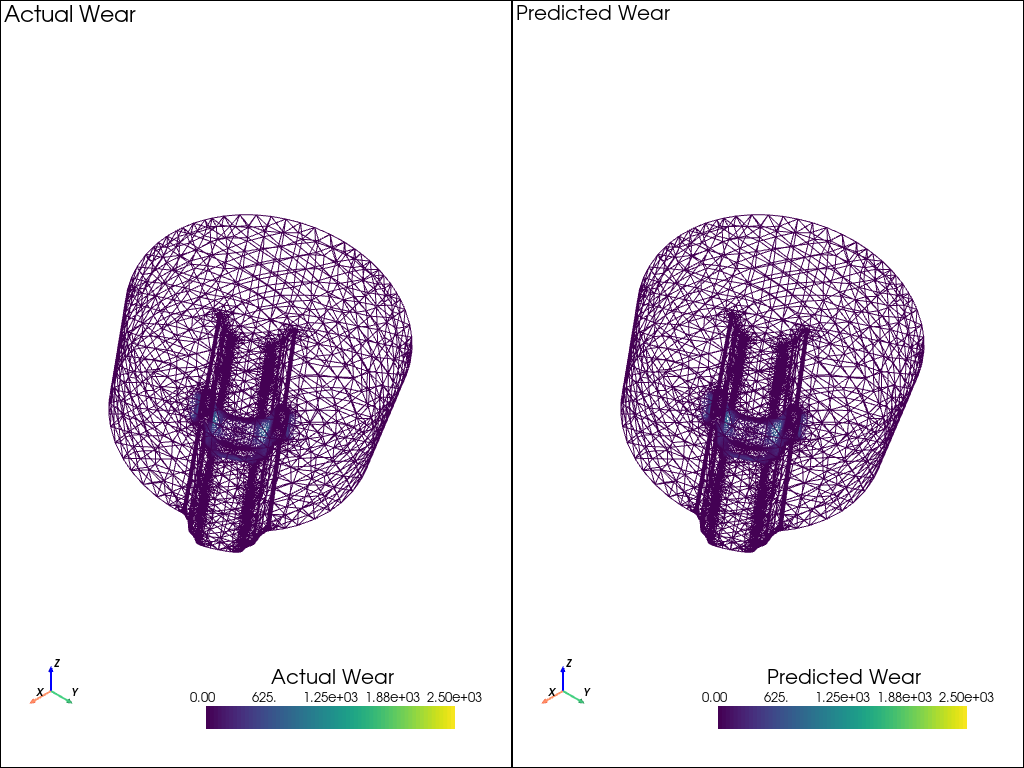

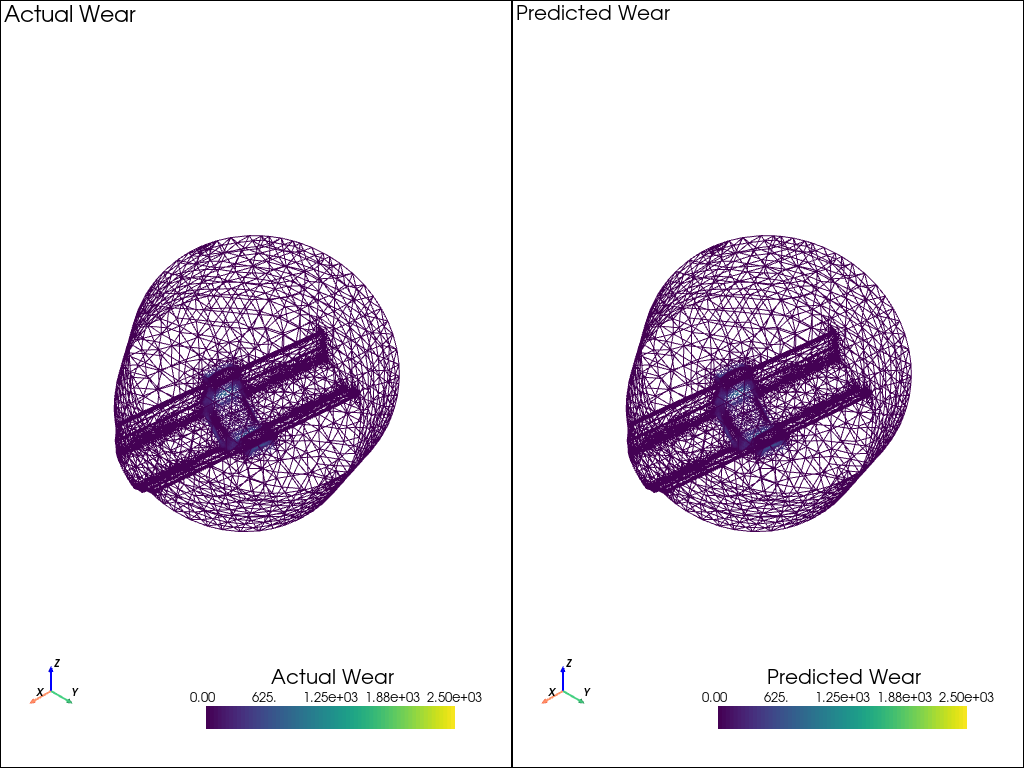

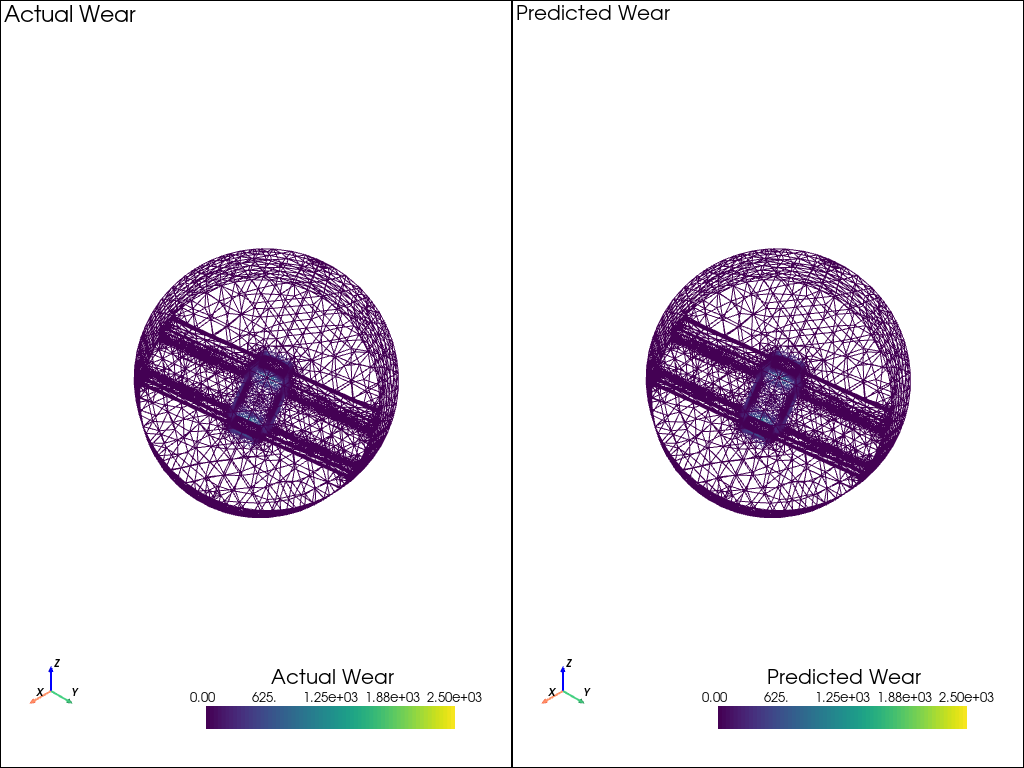

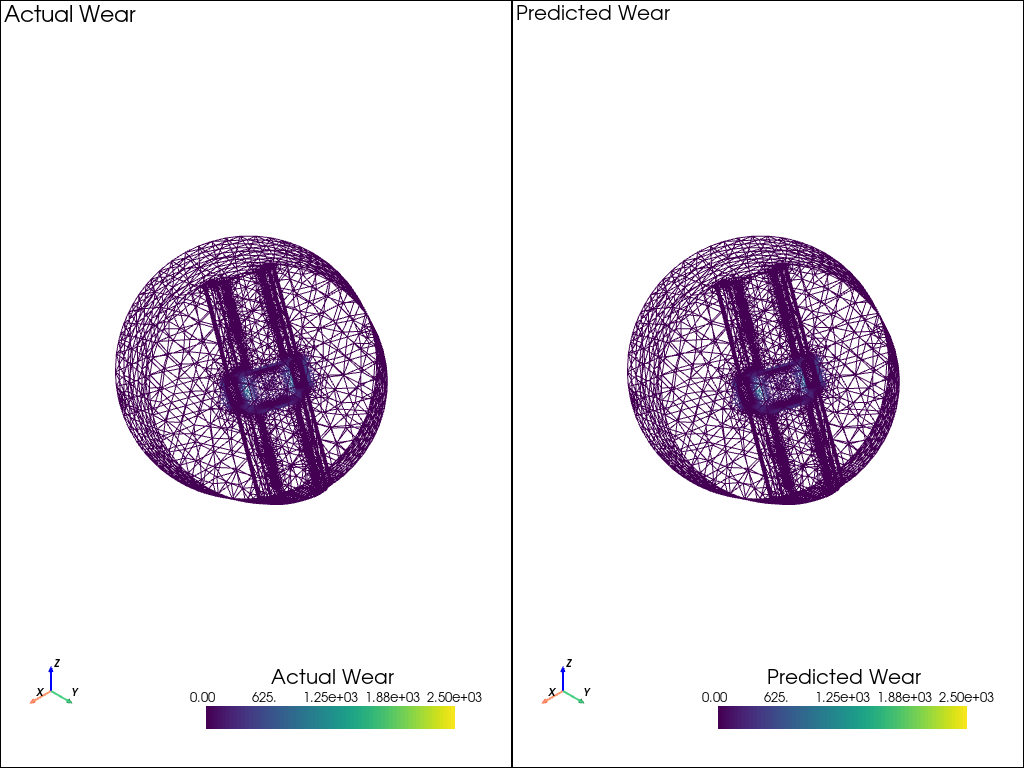

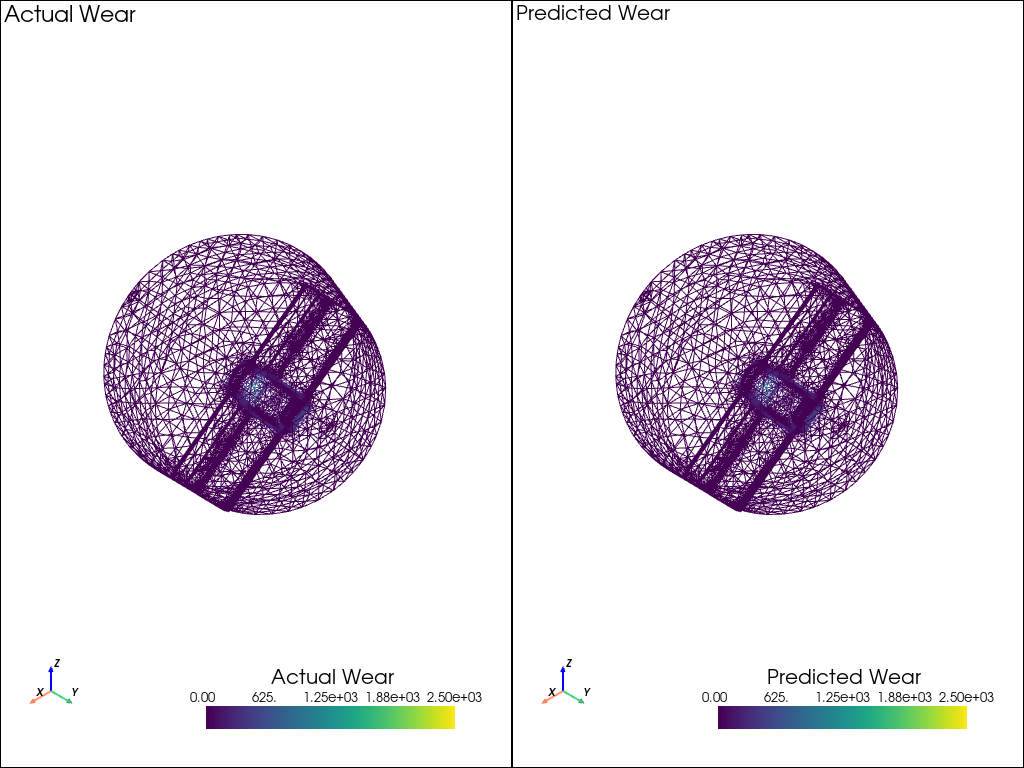

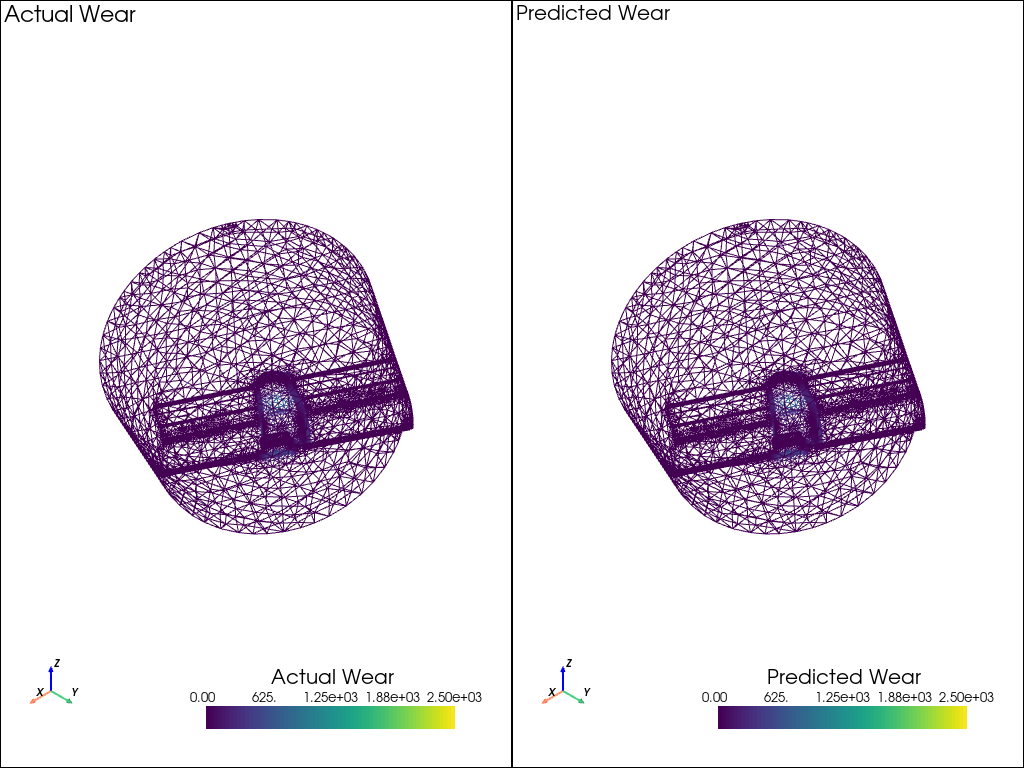

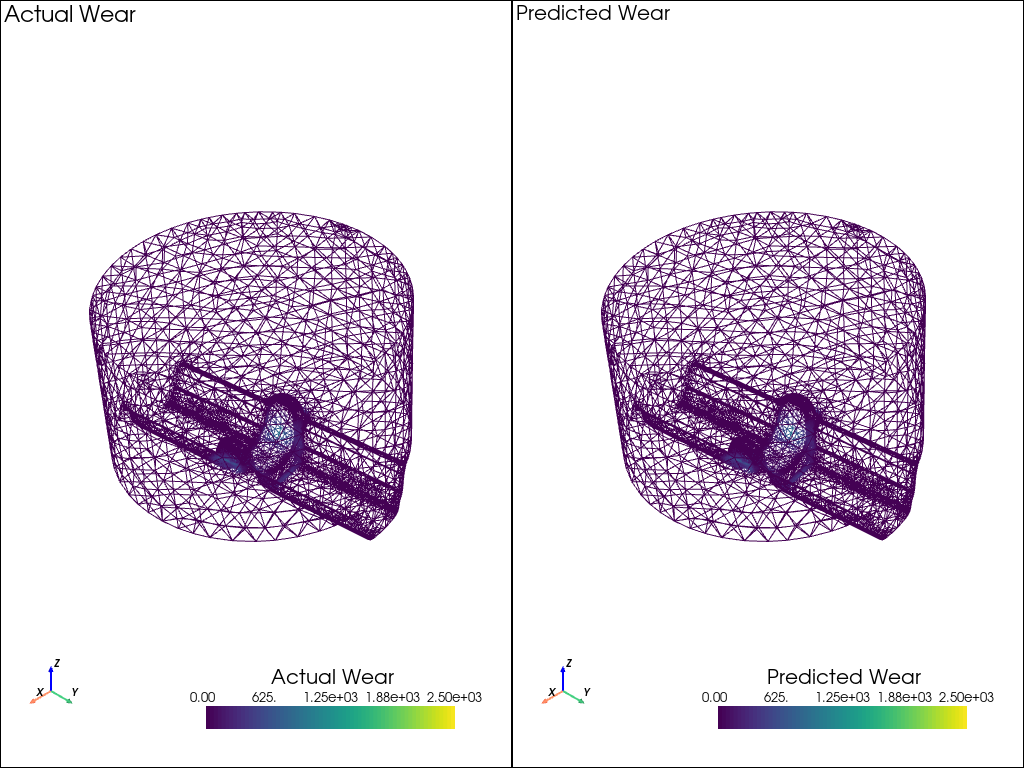

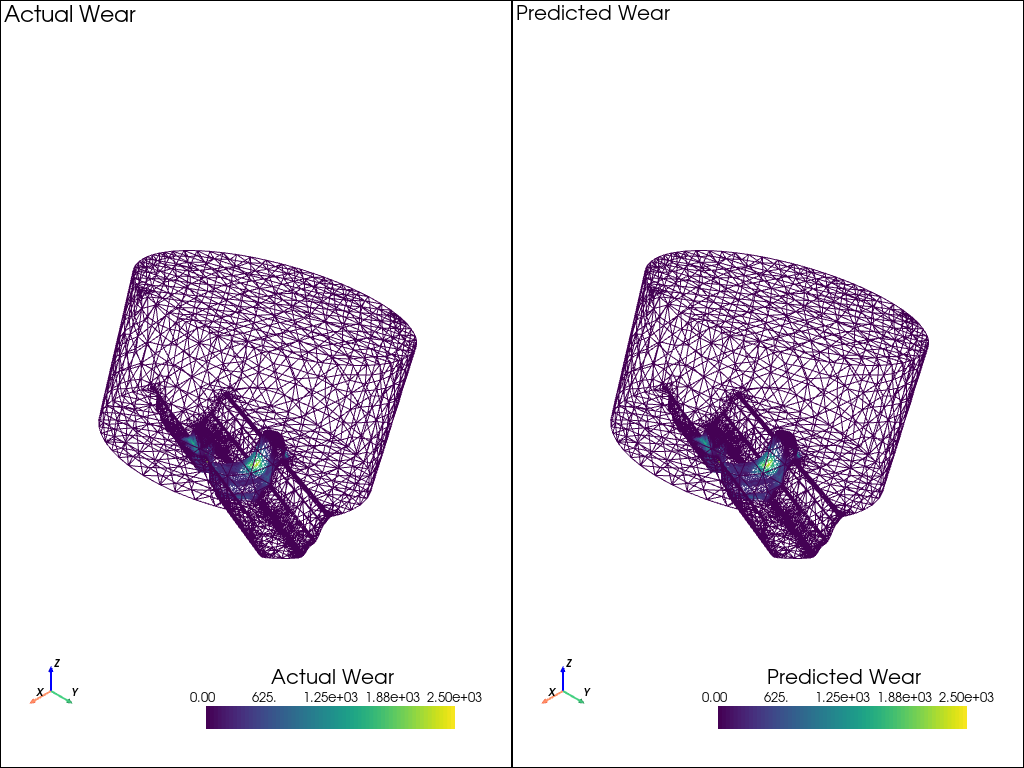

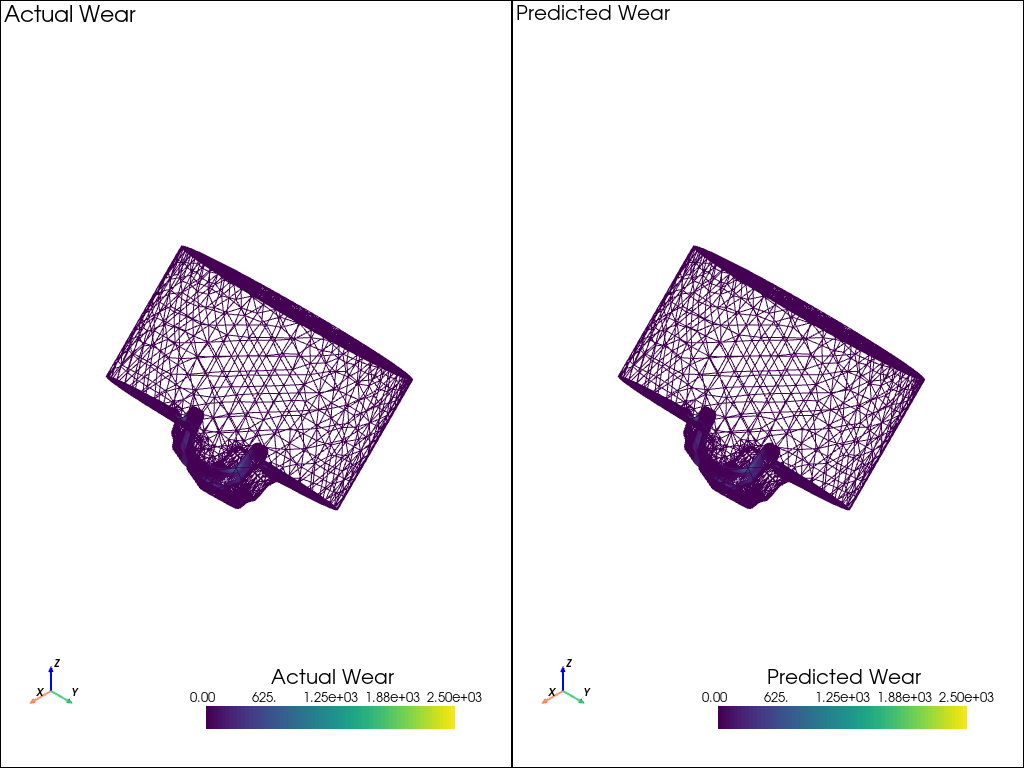

In [26]:
itera = iter(udd_test_dataloader)
for i in range(10):
    test_graph = next(itera)
    actual_wear = test_graph.ndata['label']
    predicted_wear = model_UDD(test_graph, test_graph.ndata['features']).detach().numpy()
    mesh = udd_mesh['Surface'].extract_all_edges()
    pyvista.global_theme.background = 'white'
    pyvista.global_theme.font.color = 'black'  

    plotter = pyvista.Plotter(shape=(1, 2))

    plotter.subplot(0, 0)
    plotter.add_text("Actual Wear", font_size=10, color="black")
    plotter.add_mesh(mesh.rotate_z(-25*i).rotate_x(-10*i), scalars=actual_wear, scalar_bar_args={'title': "Actual Wear"}, clim=[0, 2500])
    plotter.add_axes(interactive=True)

    plotter.subplot(0, 1)
    plotter.add_text("Predicted Wear", font_size=10, color="black")
    plotter.add_mesh(mesh.rotate_z(-25*i).rotate_x(-10*i), scalars=predicted_wear, scalar_bar_args={'title': "Predicted Wear"}, clim=[0, 2500])
    plotter.add_axes(interactive=True)

    plotter.show(jupyter_backend='static')
    plotter.screenshot(f'resimgs3dUDD/results_{i}.png')

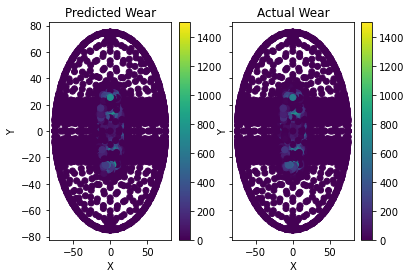

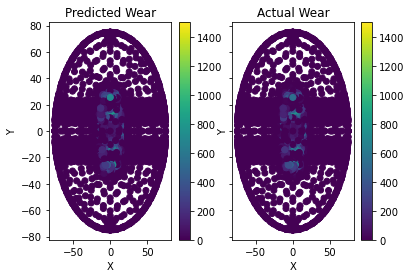

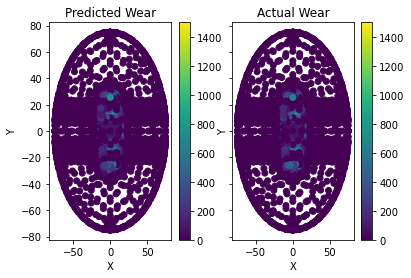

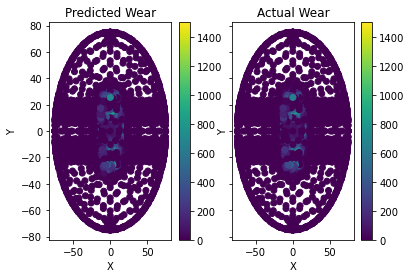

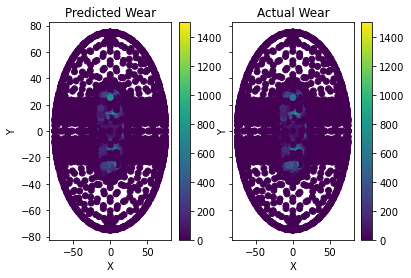

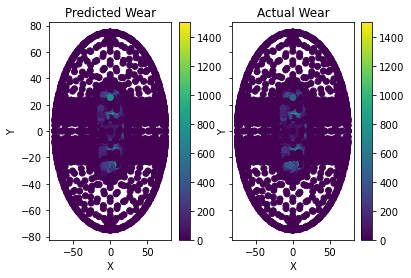

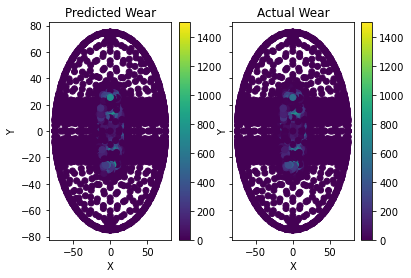

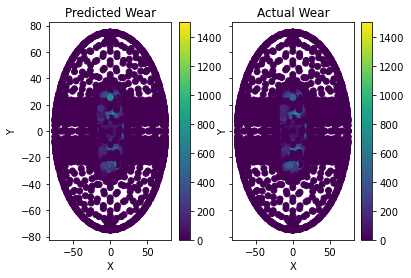

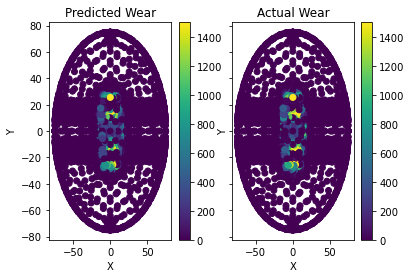

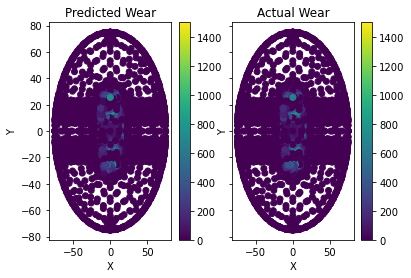

In [27]:
itera = iter(udd_test_dataloader)
for i in range(10):
    test_graph = next(itera)
    actual_wear = test_graph.ndata['label']
    predicted_wear = model_UDD(test_graph, test_graph.ndata['features']).detach().numpy()
    fig, axs = matplotlib.pyplot.subplots(1, 2, sharey=True)
    pc = test_graph.ndata['features'][:, :3]
    im1 = axs[0].scatter(pc[:, 1], pc[:, 0], c=predicted_wear)
    axs[0].set_title("Predicted Wear")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    im2 = axs[1].scatter(pc[:, 1], pc[:, 0], c=actual_wear)
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Y")
    axs[1].set_title("Actual Wear")
    fig.colorbar(im1, ax=axs[0])
    fig.colorbar(im2, ax=axs[1])
    im1.set_clim(0, 1500)
    im2.set_clim(0, 1500)
    matplotlib.pyplot.savefig(f"resimgs2dUDD/res2D_{i}.png")
    matplotlib.pyplot.show()

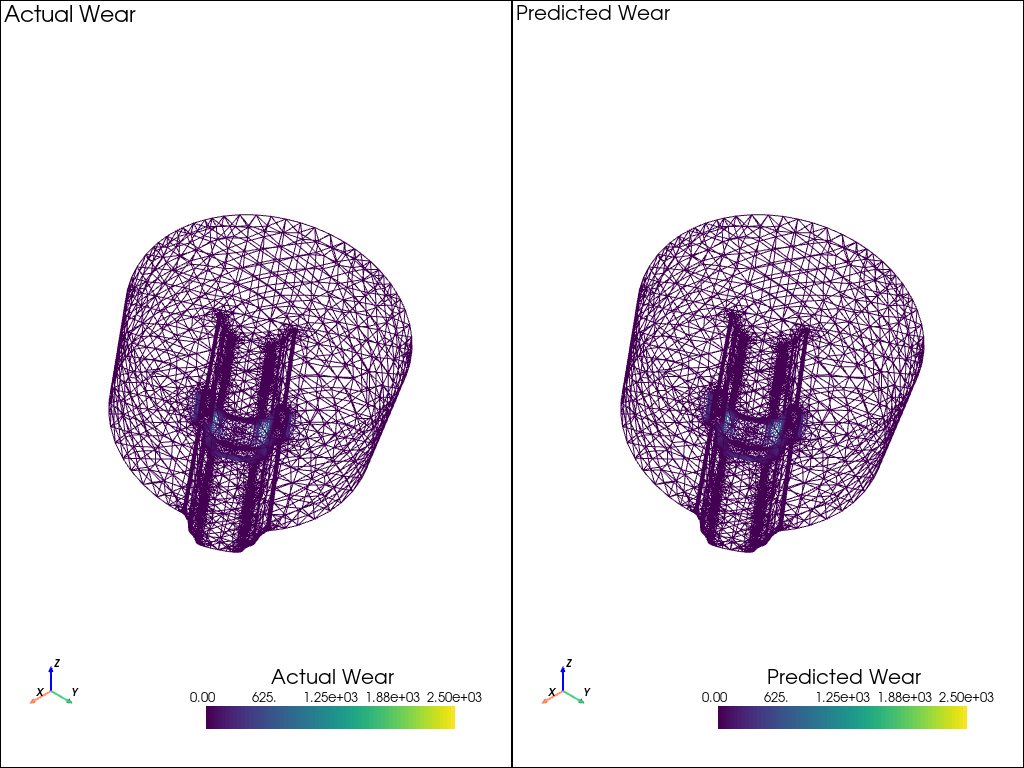

In [76]:
itera = iter(udd_test_dataloader)
test_graph = next(itera)
actual_wear = test_graph.ndata['label']
predicted_wear = model_UDD(test_graph, test_graph.ndata['features']).detach().numpy()

pyvista.global_theme.background = 'white'
pyvista.global_theme.font.color = 'black'  

plotter = pyvista.Plotter(shape=(1, 2))

plotter.subplot(0, 0)
plotter.add_text("Actual Wear", font_size=10, color="black")
plotter.add_mesh(mesh.rotate_z(0).rotate_x(0), scalars=actual_wear, scalar_bar_args={'title': "Actual Wear"}, clim=[0, 2500])
plotter.add_axes(interactive=True)

plotter.subplot(0, 1)
plotter.add_text("Predicted Wear", font_size=10, color="black")
plotter.add_mesh(mesh.rotate_z(0).rotate_x(0), scalars=predicted_wear, scalar_bar_args={'title': "Predicted Wear"}, clim=[0, 2500])
plotter.add_axes(interactive=True)

plotter.show(jupyter_backend='static')

In [ ]:
test_total_loss = 0
for input_graph in udd_test_dataloader:                       
    labels = input_graph.ndata['label']
    pred = model_UDD(input_graph, input_graph.ndata['features'])
    loss = torch.nn.functional.mse_loss(pred, labels.reshape(-1, 1)) ### MSE loss for model performance measurement
    test_total_loss += loss.detach().numpy()
test_avg_loss = test_total_loss/len(udd_test_dataloader)
print("Root Mean Squared Error on the test set on average per node is : ", numpy.sqrt(test_avg_loss))
test_r2s = []
itera = iter(udd_test_dataloader)
for i in range(10):
    test_graph = next(itera)
    actual_wear = test_graph.ndata['label']
    predicted_wear = model_UDD(test_graph, test_graph.ndata['features']).detach().numpy()
    test_r2s.append(r2_score(predicted_wear[:, 0], actual_wear))
print("Average R2 on the test data is : ", numpy.array(test_r2s).mean())

<Figure size 800x800 with 0 Axes>

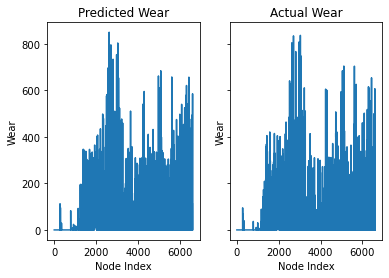

In [32]:
itera = iter(udd_test_dataloader)
test_graph = next(itera)
actual_wear = test_graph.ndata['label']
predicted_wear = model_UDD(test_graph, test_graph.ndata['features']).detach().numpy()

matplotlib.pyplot.figure(figsize=(10, 10), dpi=80)

fig, axs = matplotlib.pyplot.subplots(1, 2, sharey=True)
axs[0].plot(predicted_wear)
axs[0].set_title("Predicted Wear")
axs[0].set_xlabel("Node Index")
axs[0].set_ylabel("Wear")
axs[1].plot(actual_wear)
axs[1].set_xlabel("Node Index")
axs[1].set_ylabel("Wear")
axs[1].set_title("Actual Wear")
matplotlib.pyplot.show()

In [33]:
numpy.save("uddactwe.npy", actual_wear.numpy())
numpy.save("uddprewe.npy", predicted_wear)
#actwe = np.load('lddactwe.npy') # load

In [ ]:
fig, axs = matplotlib.pyplot.subplots(1, 2, sharey=True)
pc = test_graph.ndata['features'][:, :3]
im1 = axs[0].scatter(pc[:, 1], pc[:, 0], c=predicted_wear)
axs[0].set_title("Predicted Wear")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
im2 = axs[1].scatter(pc[:, 1], pc[:, 0], c=actual_wear)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Actual Wear")
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
matplotlib.pyplot.show()

### Testing the Baseline models for the same task
We will be testing the performance of point-net and DGNN models for object segmentation for the task of regression on the LDD and the UDD datasets. These models are point-cloud based deep learning models, and do not take the surface topological connections of the mesh into considerations. They only consider the point clouds or in other words, just the node features and not the connectivity.

In [ ]:
#### Defining the dataloaders for point cloud based deep learning models
class vtk_dataset(torch.utils.data.Dataset):
    def __init__(self, pcs):
        self.pcs = pcs
        
    def __getitem__(self, item):
        pointcloud = self.pcs[item][0][0][:, :5]
        labels = self.pcs[item][0][0][:, 5]
        return pointcloud, labels.reshape(1, -1)

    def __len__(self):
        return len(self.pcs)
X_trainldd, X_testldd = sklearn.model_selection.train_test_split(ldds, test_size=0.25)
lddtrain = vtk_dataset(X_trainldd)
lddtest = vtk_dataset(X_testldd)
lddtrain_loader = torch.utils.data.DataLoader(lddtrain, batch_size=1, shuffle=True, drop_last=True)
lddtest_loader = torch.utils.data.DataLoader(lddtest, batch_size=1, shuffle=True, drop_last=True)

X_trainudd, X_testudd = sklearn.model_selection.train_test_split(udds, test_size=0.25)
uddtrain = vtk_dataset(X_trainudd)
uddtest = vtk_dataset(X_testudd)
uddtrain_loader = torch.utils.data.DataLoader(uddtrain, batch_size=1, shuffle=True, drop_last=True)
uddtest_loader = torch.utils.data.DataLoader(uddtest, batch_size=1, shuffle=True, drop_last=True)

#### Point-Net model
For benchmarking the newly proposed model, we will be also training and evaluating the Point-Net baseline model.

In [ ]:
class PointNet(torch.nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.conv1 = torch.nn.Conv1d(5, 64, kernel_size=1, bias=False)
        self.conv2 = torch.nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv3 = torch.nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv4 = torch.nn.Conv1d(64, 128, kernel_size=1, bias=False)
        self.conv5 = torch.nn.Conv1d(128, 128, kernel_size=1, bias=False)
        self.conv6 = torch.nn.Conv1d(128, 64, kernel_size=1, bias=False)
        self.conv7 = torch.nn.Conv1d(64, 32, kernel_size=1, bias=False)
        self.conv8 = torch.nn.Conv1d(32, 1, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.bn4 = torch.nn.BatchNorm1d(128)
        self.bn5 = torch.nn.BatchNorm1d(128)
        self.bn6 = torch.nn.BatchNorm1d(64)
        self.bn7 = torch.nn.BatchNorm1d(32)

    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        x = torch.nn.functional.relu(self.bn4(self.conv4(x)))
        x = torch.nn.functional.relu(self.bn5(self.conv5(x)))
        x = torch.nn.functional.relu(self.bn6(self.conv6(x)))
        x = torch.nn.functional.relu(self.bn7(self.conv7(x)))
        x = self.conv8(x)
        return x

In [ ]:
pointnet_model = PointNet()
pointnet_model = pointnet_model.float()
opt_p = torch.optim.Adam(pointnet_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

In [ ]:
#### Training loop
train_losses = []
test_losses = []
for epoch in range(500):
    ####################
    # Train
    ####################
    train_loss = 0.0
    count = 0.0
    train_pred = []
    train_true = []
    pointnet_model.train()
    for data, label in lddtrain_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        opt_p.zero_grad()
        output = pointnet_model(data.float())
        loss = criterion(output, label.float())
        loss.backward()
        opt_p.step()
        count += batch_size
        train_loss += loss.item() * batch_size
    outstr = 'Train %d, loss: %.6f' % (epoch,train_loss*1.0/count)
    train_losses.append(train_loss*1.0/count)
    print(outstr)
    pointnet_model.eval()
    test_loss = 0.0
    count = 0.0
    for data, label in lddtest_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        output = pointnet_model(data.float())
        loss = criterion(output, label.float())
        count += batch_size
        test_loss += loss.item() * batch_size
    outstr = 'Test %d, Testing ==> loss: %.6f' % (epoch, test_loss*1.0/count)
    test_losses.append(test_loss*1.0/count)
    print(outstr)
matplotlib.pyplot.plot(train_losses, label="Train Loss")
matplotlib.pyplot.plot(test_losses, label="Test Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [ ]:
pointnet_model = PointNet()
pointnet_model = pointnet_model.float()
opt_p = torch.optim.Adam(pointnet_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.MSELoss()
#### Training loop
train_losses = []
test_losses = []
for epoch in range(500):
    ####################
    # Train
    ####################
    train_loss = 0.0
    count = 0.0
    train_pred = []
    train_true = []
    pointnet_model.train()
    for data, label in uddtrain_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        opt_p.zero_grad()
        output = pointnet_model(data.float())
        loss = criterion(output, label.float())
        loss.backward()
        opt_p.step()
        count += batch_size
        train_loss += loss.item() * batch_size
    outstr = 'Train %d, loss: %.6f' % (epoch,train_loss*1.0/count)
    train_losses.append(train_loss*1.0/count)
    print(outstr)
    pointnet_model.eval()
    test_loss = 0.0
    count = 0.0
    for data, label in uddtest_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        output = pointnet_model(data.float())
        loss = criterion(output, label.float())
        count += batch_size
        test_loss += loss.item() * batch_size
    outstr = 'Test %d, Testing ==> loss: %.6f' % (epoch, test_loss*1.0/count)
    test_losses.append(test_loss*1.0/count)
    print(outstr)
matplotlib.pyplot.plot(train_losses, label="Train Loss")
matplotlib.pyplot.plot(test_losses, label="Test Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [ ]:
pointnet_model.eval()
test_loss = 0.0
count = 0.0
r2s = []
for data, label in uddtest_loader:
    data = data.permute(0, 2, 1)
    batch_size = data.size()[0]
    output = pointnet_model(data.float())
    predicted_wear = output[0, 0, :].detach().numpy()
    actual_wear = label[0, 0, :].detach().numpy()
    r2s.append(r2_score(predicted_wear, actual_wear))
print("Average R2 score on the testing data is : ", numpy.array(r2s).mean())

### DGNN model

In [ ]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=5, idx=None, dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        if dim9 == False:
            idx = knn(x, k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    device = torch.device('cpu')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature      # (batch_size, 2*num_dims, num_points, k)

In [ ]:
class DGCNN_seg(torch.nn.Module):
    def __init__(self, k, emb_dims, dropout):
        super(DGCNN_seg, self).__init__()
        self.k = k
        self.emb_dims = emb_dims
        self.dropout = dropout
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.bn5 = torch.nn.BatchNorm2d(64)
        self.bn6 = torch.nn.BatchNorm1d(self.emb_dims)
        self.bn7 = torch.nn.BatchNorm1d(512)
        self.bn8 = torch.nn.BatchNorm1d(256)

        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(10, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn3,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn4,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = torch.nn.Sequential(torch.nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn5,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv6 = torch.nn.Sequential(torch.nn.Conv1d(192, self.emb_dims, kernel_size=1, bias=False),
                                   self.bn6,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv7 = torch.nn.Sequential(torch.nn.Conv1d(256, 512, kernel_size=1, bias=False),
                                   self.bn7,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.conv8 = torch.nn.Sequential(torch.nn.Conv1d(512, 256, kernel_size=1, bias=False),
                                   self.bn8,
                                   torch.nn.LeakyReLU(negative_slope=0.2))
        self.dp1 = torch.nn.Dropout(p=self.dropout)
        self.conv9 = torch.nn.Conv1d(256, 1, kernel_size=1, bias=False)
        

    def forward(self, x):
        batch_size = x.size(0)
        num_points = x.size(2)

        x = get_graph_feature(x, k=self.k, dim9=True)   # (batch_size, 9, num_points) -> (batch_size, 9*2, num_points, k)
        x = self.conv1(x)                       # (batch_size, 9*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv2(x)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x1 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x1, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv3(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv4(x)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x2 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x2, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv5(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x3 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = torch.cat((x1, x2, x3), dim=1)      # (batch_size, 64*3, num_points)

        x = self.conv6(x)                       # (batch_size, 64*3, num_points) -> (batch_size, emb_dims, num_points)
        x = x.max(dim=-1, keepdim=True)[0]      # (batch_size, emb_dims, num_points) -> (batch_size, emb_dims, 1)

        x = x.repeat(1, 1, num_points)          # (batch_size, 1024, num_points)
        x = torch.cat((x, x1, x2, x3), dim=1)   # (batch_size, 1024+64*3, num_points)

        x = self.conv7(x)                       # (batch_size, 1024+64*3, num_points) -> (batch_size, 512, num_points)
        x = self.conv8(x)                       # (batch_size, 512, num_points) -> (batch_size, 256, num_points)
        x = self.dp1(x)
        x = self.conv9(x)                       # (batch_size, 256, num_points) -> (batch_size, 13, num_points)
        
        return x

In [ ]:
dgcnn_model = DGCNN_seg(k=5, emb_dims=64, dropout=0.0)
dgcnn_model = dgcnn_model.float()
opt_dgcnn = torch.optim.Adam(dgcnn_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

In [ ]:
train_losses = []
test_losses = []
for epoch in range(100):
    ####################
    # Train
    ####################
    train_loss = 0.0
    count = 0.0
    train_pred = []
    train_true = []
    dgcnn_model.train()
    for data, label in lddtrain_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        opt_p.zero_grad()
        output = dgcnn_model(data.float())
        loss = criterion(output, label.float())
        loss.backward()
        opt_p.step()
        count += batch_size
        train_loss += loss.item() * batch_size
    outstr = 'Train %d, loss: %.6f' % (epoch,train_loss*1.0/count)
    train_losses.append(train_loss*1.0/count)
    print(outstr)
    dgcnn_model.eval()
    test_loss = 0.0
    count = 0.0
    for data, label in lddtest_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        output = dgcnn_model(data.float())
        loss = criterion(output, label.float())
        count += batch_size
        test_loss += loss.item() * batch_size
    outstr = 'Test %d, Testing ==> loss: %.6f' % (epoch, test_loss*1.0/count)
    test_losses.append(test_loss*1.0/count)
    print(outstr)
matplotlib.pyplot.plot(train_losses, label="Train Loss")
matplotlib.pyplot.plot(test_losses, label="Test Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [ ]:
dgcnn_model = DGCNN_seg(k=5, emb_dims=64, dropout=0.0)
dgcnn_model = dgcnn_model.float()
opt_dgcnn = torch.optim.Adam(dgcnn_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

train_losses = []
test_losses = []
for epoch in range(10):
    ####################
    # Train
    ####################
    train_loss = 0.0
    count = 0.0
    train_pred = []
    train_true = []
    dgcnn_model.train()
    for data, label in uddtrain_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        opt_p.zero_grad()
        output = dgcnn_model(data.float())
        loss = criterion(output, label.float())
        loss.backward()
        opt_p.step()
        count += batch_size
        train_loss += loss.item() * batch_size
    outstr = 'Train %d, loss: %.6f' % (epoch,train_loss*1.0/count)
    train_losses.append(train_loss*1.0/count)
    print(outstr)
    dgcnn_model.eval()
    test_loss = 0.0
    count = 0.0
    for data, label in uddtest_loader:
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        output = dgcnn_model(data.float())
        loss = criterion(output, label.float())
        count += batch_size
        test_loss += loss.item() * batch_size
    outstr = 'Test %d, Testing ==> loss: %.6f' % (epoch, test_loss*1.0/count)
    test_losses.append(test_loss*1.0/count)
    print(outstr)
matplotlib.pyplot.plot(train_losses, label="Train Loss")
matplotlib.pyplot.plot(test_losses, label="Test Loss")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()